# Drone Tabanlı Deprem Sonrası İnsani Yardım Dağıtım Optimizasyonu 

Bu projede öğrenciler, bir afet sonrasında insani yardım malzemelerinin dağıtımı için 
optimizasyon algoritmaları kullanarak, dronlar aracılığıyla yardımların ihtiyaç 
noktalarına en hızlı ve en verimli şekilde ulaştırılmasını sağlayacak bir sistem 
geliştireceklerdir. 
Dağıtım rotalarının optimizasyonu, ihtiyaç noktalarının 
gruplandırılması ve yükleme stratejileri gibi unsurları göz önünde bulunduracaklardır. 

# Detaylar:



**1**.İhtiyaç Noktaları ve Depolar: 

o İhtiyaç Noktası Sayısı: Toplamda 40-50 arasında farklı ihtiyaç noktası. 

o Depo Sayısı: 2 adet depo (Kuzey, Güney bölgelerinde). 

o Yardım Malzemeleri: Tıbbi malzeme ve yiyecek olmak üzere iki ana 
yardım türü. (A-B) olarak isimlendirme yapabilirsiniz. 

o Drone Kapasitesi: Her drone maksimum 30 birim yardım malzemesi 
taşıyabilir (tıbbi veya yiyecek veya her ikiside). 

**2**. Excel Dosyası Hazırlığı:
Öğrencilerin aşağıdaki bilgileri içeren iki farklı Excel 
dosyası hazırlamaları gerekmektedir: 

o İhtiyaç Noktaları Mesafeleri Dosyası: İhtiyaç noktalarının birbirlerine ve 
depolara olan uzaklıklarını (km cinsinden) içeren bir tablo. 

o Yardım Talep Dosyası: Her ihtiyaç noktasının, her bir depodan kaç adet 
tıbbi malzeme ve yiyecek talep ettiğini gösteren bir tablo 

**3**. Kümeleme (Clustering): 

oluşturulan mesafeler tablosunu 
kullanarak ihtiyaç noktalarını aralarındaki mesafeler doğrultusunda kümeler 
halinde gruplandıracaklardır. k-means algoritması kullanılacak.

**4**.Rota Optimizasyonu: 

Her küme içerisindeki ihtiyaç noktaları arasında dağıtımı 
en kısa sürede gerçekleştirmek için dronların izleyeceği en kısa yolu 
planlamaları gerekmektedir. Bunun için A* algoritması kullanılacak.

**5**. Yükleme Stratejisi: 


o Dronlar, toplamda 30 birim yardım malzemesi taşıyabilmektedir. Bir 
ihtiyaç noktasının talep ettiği yardım malzemelerinin tamamı drona 
sığmıyorsa, o ihtiyacın karşılanması sonraki drone ile sağlanacaktır. 
o Drone tam kapasitesine ulaşmasa bile, taşıdığı malzemeler ilgili ihtiyaç 
noktalarının talep ettiği yardımları kapsamalıdır. 

# Başlangıç 


In [38]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx
from heapq import heappop, heappush

# Excel'den Veri Okuma
distances = pd.read_excel("/workspaces/Machine-Learninig-Project/in.xlsx", index_col=0)
aid_demand = pd.read_excel("/workspaces/Machine-Learninig-Project/yt.xlsx", index_col=0)

# Depoların Koordinatları
depots = {
    "Kuzey Depo": (0, 100),
    "Güney Depo": (0, -100),
    "Doğu Depo": (100, 0)
}

# Koordinatları Hazırlama (İhtiyaç Noktaları)
needs_coords = pd.DataFrame(index=aid_demand.index)
needs_coords["X"] = np.random.randint(-100, 100, size=len(needs_coords))
needs_coords["Y"] = np.random.randint(-100, 100, size=len(needs_coords))
needs_coords["En Yakın Depo"] = aid_demand["En Yakın Depo"]

# Kümeleme (k=5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
needs_coords["Cluster"] = kmeans.fit_predict(needs_coords[["X", "Y"]])

In [39]:

# A* Algoritması
def a_star_algorithm(graph, start, goal):
    open_list = [(0, start)]  # (cost, node)
    came_from = {}
    cost_so_far = {start: 0}
    
    while open_list:
        current_cost, current_node = heappop(open_list)
        if current_node == goal:
            break
        for neighbor in graph.neighbors(current_node):
            weight = graph.edges[current_node, neighbor]['weight']
            new_cost = cost_so_far[current_node] + weight
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                heappush(open_list, (new_cost, neighbor))
                came_from[neighbor] = current_node
    
    path = []
    node = goal
    while node != start:
        path.append(node)
        node = came_from[node]
    path.append(start)
    path.reverse()
    return path, cost_so_far[goal]

In [40]:

def create_graph(cluster_df):
    G = nx.Graph()
    for i, row1 in cluster_df.iterrows():
        for j, row2 in cluster_df.iterrows():
            if i != j:
                dist = np.sqrt((row1["X"] - row2["X"])**2 + (row1["Y"] - row2["Y"])**2)
                G.add_edge(i, j, weight=dist)
    return G

optimized_routes = {}

for cluster in sorted(needs_coords["Cluster"].unique()):
    cluster_df = needs_coords[needs_coords["Cluster"] == cluster].copy()  # copy() ekledim
    depo_name = cluster_df["En Yakın Depo"].iloc[0]
    depo_coord = depots[depo_name]
    depot_index = f"{depo_name}_Cluster{cluster}"
    cluster_df.loc[depot_index] = {"X": depo_coord[0], "Y": depo_coord[1], "Cluster": cluster, "En Yakın Depo": depo_name}
    G = create_graph(cluster_df)
    all_nodes = cluster_df.index.tolist()
    all_nodes.remove(depot_index)
    path, total_cost = a_star_algorithm(G, depot_index, all_nodes[0])
    for target_node in all_nodes[1:]:
        partial_path, cost = a_star_algorithm(G, path[-1], target_node)
        path.extend(partial_path[1:])
        total_cost += cost
    optimized_routes[cluster] = {"path": path, "total_cost": total_cost}


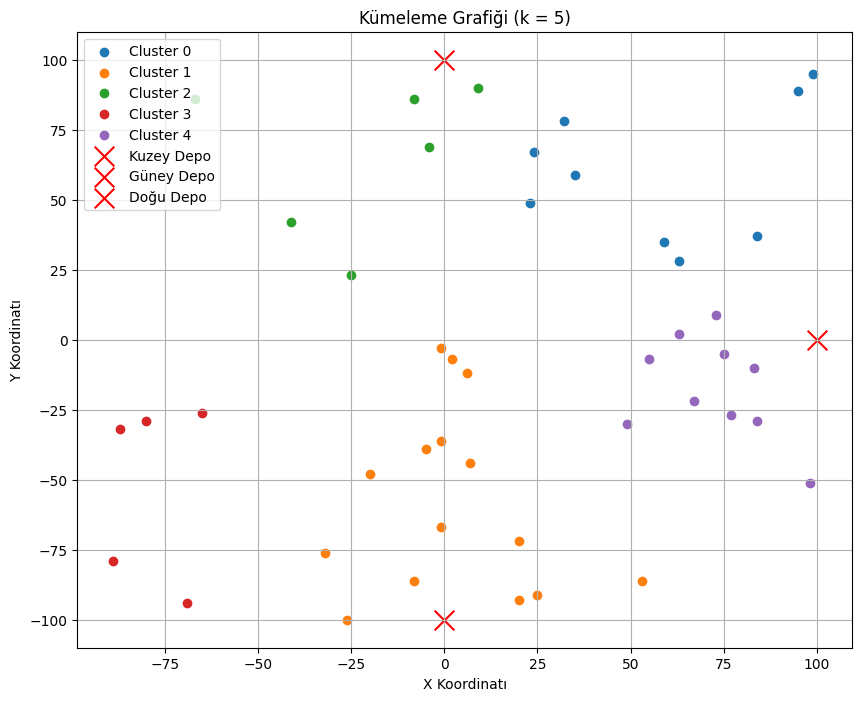

Rota Optimizasyon Sonuçları:
Küme 0: Rota: ['Kuzey Depo_Cluster0', 'İhtiyaç Noktası 8', 'İhtiyaç Noktası 10', 'İhtiyaç Noktası 13', 'İhtiyaç Noktası 17', 'İhtiyaç Noktası 22', 'İhtiyaç Noktası 27', 'İhtiyaç Noktası 40', 'İhtiyaç Noktası 43', 'İhtiyaç Noktası 44'], Toplam Maliyet: 489.76
Küme 1: Rota: ['Güney Depo_Cluster1', 'İhtiyaç Noktası 2', 'İhtiyaç Noktası 5', 'İhtiyaç Noktası 6', 'İhtiyaç Noktası 9', 'İhtiyaç Noktası 11', 'İhtiyaç Noktası 15', 'İhtiyaç Noktası 16', 'İhtiyaç Noktası 18', 'İhtiyaç Noktası 21', 'İhtiyaç Noktası 28', 'İhtiyaç Noktası 31', 'İhtiyaç Noktası 35', 'İhtiyaç Noktası 36', 'İhtiyaç Noktası 38', 'İhtiyaç Noktası 39'], Toplam Maliyet: 822.20
Küme 2: Rota: ['Kuzey Depo_Cluster2', 'İhtiyaç Noktası 1', 'İhtiyaç Noktası 7', 'İhtiyaç Noktası 12', 'İhtiyaç Noktası 26', 'İhtiyaç Noktası 41', 'İhtiyaç Noktası 45'], Toplam Maliyet: 330.44
Küme 3: Rota: ['Kuzey Depo_Cluster3', 'İhtiyaç Noktası 20', 'İhtiyaç Noktası 23', 'İhtiyaç Noktası 29', 'İhtiyaç Noktası 33', 'İhtiy

In [41]:

# Kümeleme ve Depo Grafiği
plt.figure(figsize=(10, 8))
for cluster in sorted(needs_coords["Cluster"].unique()):
    cluster_points = needs_coords[needs_coords["Cluster"] == cluster]
    plt.scatter(cluster_points["X"], cluster_points["Y"], label=f"Cluster {cluster}")
for depo, coord in depots.items():
    plt.scatter(coord[0], coord[1], color='red', marker='x', s=200, label=f"{depo}")
plt.title("Kümeleme Grafiği (k = 5)")
plt.xlabel("X Koordinatı")
plt.ylabel("Y Koordinatı")
plt.legend()
plt.grid(True)
plt.show()

print("Rota Optimizasyon Sonuçları:")
for cluster, info in optimized_routes.items():
    print(f"Küme {cluster}: Rota: {info['path']}, Toplam Maliyet: {info['total_cost']:.2f}")
